# ASTR 596: FDS - The Midterm


    
### Dun, dun dun. 
#### (suspenseful music here)

## Start with the Cepheid data you have already seen in lecture 03 and 04.

## There are measurements of several Cepheid variable stars in each of 9 nearby galaxies.

## Begin by reading this code and familiarizing yourself with what attributes and functions are available to you. In particular, it will help to read comments at the top of the data file.


In [1]:
exec(open('cepheids.py').read())
ceph = Cepheids('../../data/03/R11ceph.dat')
hosts = ceph.list_hosts()

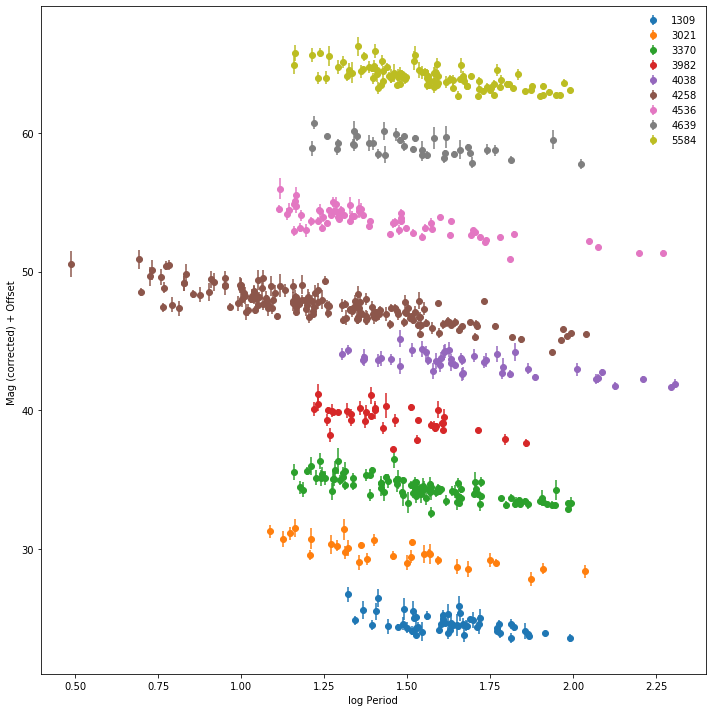

In [2]:
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

for i, ID in enumerate(hosts):
    ceph.select(ID)
    mobs = ceph.mobs
    logP = ceph.logP
    sigma_obs = ceph.sigma
    ax.errorbar(logP, mobs+(5*i), yerr=sigma_obs, linestyle='None', marker='o', label=ID)
    
ax.legend(frameon=False)
ax.set_xlabel('log Period')
ax.set_ylabel('Mag (corrected) + Offset ')
fig.tight_layout()

# Q1.

## This data was taken from [Riess et al., 2011](https://arxiv.org/abs/1103.2976)

## The global model for the magnitudes of these Cepheids is given in Equation 1. You may ignore the effect of metalicity

## Some parameters (such as distance modulus) are specific to each galaxy.

## Others are common to all galaxies. 

## Assuming Gaussian magnitude errors and no period error (and you may ignore metallicity entirely), but that Cepheids scatter off the period-luminosity relation because of some Gaussian intrinsic dispersion $\sigma_{\text{int}}$, write down your expression for the likelihood being careful to use the same indices that Riess et. al used.


<hr>
<font color="green">

### Eqn. 1 of Riess et al. 2011 specifies the model (ignoring metallicity) as 


# $$ m_{W_{i,j}} = (\mu_{0, i} - \mu_{0, 4258}) + zp_{W,4258} + b_W \log P_{i,j}$$

### where $i$ is an index over the galaxies and $j$ is an index over the cepheids in each galaxy.


### The plot above doesn't have much evidence of large outliers, particularly considering some intrinsic scatter about the Leavitt law (Cepheid period luminosity relation), so we'll assert a simple normal likelihood. We can write the negative log-likelihood as:

# $$ -\log L \propto \sum_{i}\sum_{j} \frac{ (m_{W_{i,j}} - (\mu_{0, i} - \mu_{0, 4258}) - zp_{W,4258} - b_W \log P_{i,j})^2}{ \sigma^2_{m_{W_{i,j}}} + \sigma_{\text{int}}^2 } $$

### This formulation is simpler than it looks at first glance. The complexity is because of the intercept term $(\mu_{0, i} - \mu_{0, 4258}) + zp_{W,4258}$. 

### We don't know the true absolute magnitude of the cepheids, so it's expressed relative to NGC4258. The first term is (by definition) zero for NGC4258 itself, while $zp_{W,4258}$ is set only by NGC4258. Riess et al. accomplish this using an iterated fit, where they model NGC4258, and then all the other galaxies. We're going to simply do this in one step, where there is a single global Cepheid zeropoint and then distances are set relative to NGC4258.

### The slope is set by the global fit to all Cepehids per the paper (as is the metallicity term, but I'm having you ignore this). 
    
### The other complexity is the errors underestimate the scatter in the data. Riess et al. eliminate outliers with residuals > 0.75 mag, and have a variety of justifications for this, but you can quite righly feel queasy about it. We're going to introduce the $\sigma_{\text{int}}$ to deal with it. The problem is that we can't just treat $\sigma_{\text{int}}$ as a free parameter because of how it appears in the likelihood - the easiest way to minimize chi-squared is to simply allow it to become as large as possible. Riess et al. have a different solution - they just add a flat value in quadrature. We'll figure out what value to use later.

    
</font>
<hr>


# Q2. 

## Given what you know for each of the parameters in this model, write down physically motivated (i.e. not just top hats on everything) priors, along with your explanation.

## Think particularly about the priors for distances to each galaxy.

<hr>
<font color="green">

### The slope in the Leavitt law is clearly negative. We'd like a prior that does not bias the measurement of slope, so following what we did in class 

# $$ P(b_W) = (1+b_W^2)^{-3/2} \cdot U (-5, 0) $$ 
       
### For the relative intercepts, which are just the distance moduli for the galaxies - the distance modulus for NGC4258, we can just use a Half Normal with a broad width (say 5 mag) - since we know that NGC4258 is the closest host to us, we can demand these relative distances are all positive.
    
### For NGC4258 we can use the value we'd predict from a nominal cosmology, also with a broad width.  
    
### We can check that these widths are reasonable by comparing the relative distances to what we get from some nominal cosmology.
    
</font>
<hr>

In [3]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
mu_4258 = cosmo.distmod(ceph.redshifts['4258'])

mu_prior = {host:(cosmo.distmod(z)-mu_4258) if host!='4258' else mu_4258 for host, z in ceph.redshifts.items() }
for host in hosts:
    val = mu_prior[host]
    print(f'{host}: {val:.3f}')

1309: 3.402 mag
3021: 2.689 mag
3370: 2.283 mag
3982: 1.972 mag
4038: 2.828 mag
4258: 29.033 mag
4536: 3.038 mag
4639: 1.786 mag
5584: 2.822 mag


<font color='green'>

### All these are well less than the width of the Gaussian I'm employing.
    
</font>

# Q3. 

## Implement this likelihood and prior in python and sample the posterior distribution with emcee.

## Construct traceplots for each parameter, as well as corner plots for each pair of parameters.


## If your Markov Chains are reasonable, verify that your model fits are reasonable by reconstructing Fig. 7 of Riess et al. 2011

## Compare the intercept you find for the intercepts $\mu_{0,i} - \mu_{0, 4258}$ vs Table 3 of Riess et al. 2011

<font color="green">
<hr>

### First we can solve a simpler problem - treating the galaxies separately. 

### This also gets us a reasonable initial guess as well. 
 
### We can just use weighted least squares for each host. 

</font> 
   
<hr>


In [4]:
import numpy as np 
import scipy.stats as st
import emcee
import corner
from scipy.optimize import minimize
from uncertainties import ufloat

median error 0.37
reduced chisq 3.7608239701592527


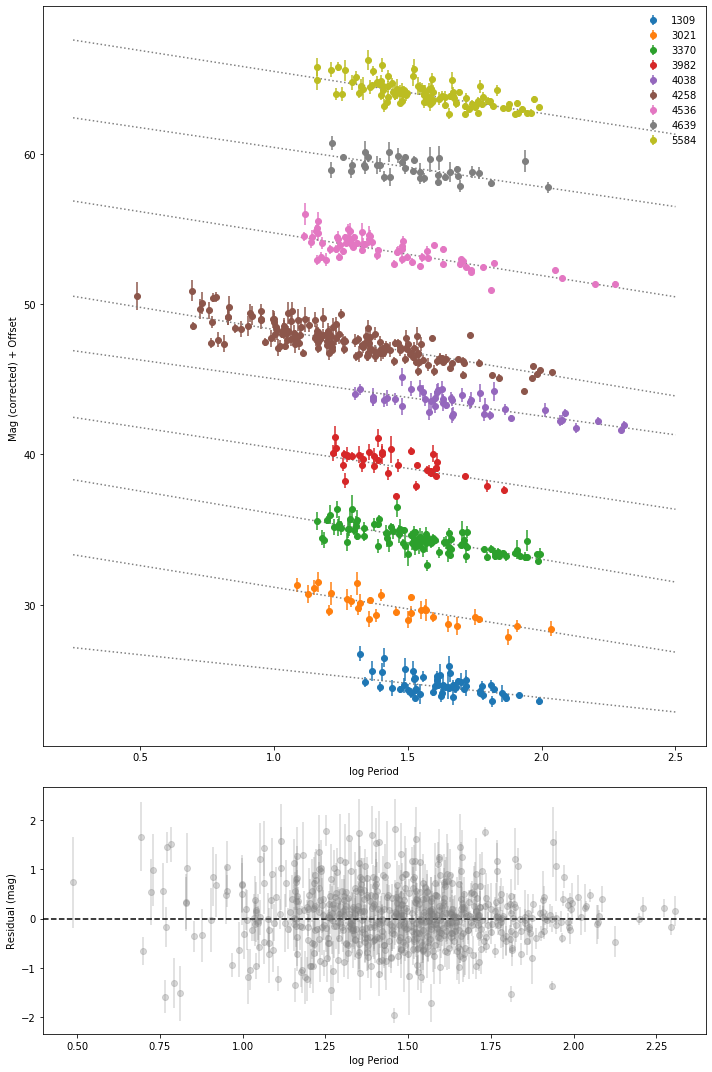

In [5]:
# define a likelihood for each Cepehid galaxy
def neg_log_like(theta, i):
    ceph.select(hosts[i])
    mobs = ceph.mobs
    logP = ceph.logP
    sigma_obs = ceph.sigma
    b, mu = theta
    return np.sum((mobs - b*logP - mu)**2./(sigma_obs**2.))

# create some structures to keep track of all the residuals and the measurement uncertainties, and results
all_res = []
all_sig = []
results = []

gridspec_kw={'height_ratios':[3,1]}
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 15), gridspec_kw=gridspec_kw)
ax, ax2 = axs
logPgrid = np.linspace(0.25, 2.5, 10, endpoint=True)

for i, ID in enumerate(hosts):
    ceph.select(ID)
    mobs = ceph.mobs
    logP = ceph.logP
    sigma_obs = ceph.sigma
    ax.errorbar(logP, mobs+(5*i), yerr=sigma_obs, linestyle='None', marker='o', label=ID)
    
    # fit each of the Cepehid galaxies
    res = minimize(neg_log_like, (-2., np.median(mobs)), args=(i,))
    
    # plot the fit
    ax.plot(logPgrid, res.x[0]*logPgrid + res.x[1] + 5*i, color='grey', ls=':')
    
    # save the results, residuals and uncertainties
    results.append(res.x)
    residual = mobs - res.x[0]*logP - res.x[1]
    all_res += list(residual)
    all_sig += list(sigma_obs)
    
    # plot the residuals
    ax2.errorbar(logP, residual, yerr=sigma_obs, linestyle='None', marker='o', color='grey', alpha=0.3 )

ax2.axhline(0, linestyle='--', color='k')

# determine the median error and the reduced chi-squared
all_res = np.array(all_res)
all_sig = np.array(all_sig)
full_chisq = np.mean((all_res/all_sig)**2.)
print('median error', np.median(all_sig))
print('reduced chisq', full_chisq)


ax.legend(frameon=False)
ax.set_xlabel('log Period')
ax.set_ylabel('Mag (corrected) + Offset ')
ax2.set_xlabel('log Period')
ax2.set_ylabel('Residual (mag)')
fig.tight_layout()

In [6]:
# get a guess for all the slopes and intercepts
results = np.array(results)

#we're going to save the index of NGC4258 as a variable 
ind4258 = np.where(hosts =='4258')[0]


guess_bW = np.median(results[:,0])

# get an estimate of the additional variance that needs to be added to the data to get a reduced chisq of ~unity
sig_int = np.sqrt((full_chisq-1)*np.median(all_sig)**2.)
print(f'Additional intrinsic dispersion for reduced chisq of unity = {sig_int:.3f}')

guess = [guess_bW, ] 
mu_4258 = results[ind4258,1][0]
guess += [results[i,1] - mu_4258 if host !='4258' else mu_4258 for i, host in enumerate(hosts) ]

guess = np.array(guess)
print('Initial guess:', guess)


Additional intrinsic dispersion for reduced chisq of unity = 0.615
Initial guess: [-2.78757566  1.36190158  2.78461851  2.81277449  1.88695622  1.26470689
 26.26490177  1.3107814   1.79434045  2.00938204]


In [7]:
def log_prior(theta): 
    global ind4258
    bW      = theta[0]
    mu      = theta[1:]
    mu4258  = theta[ind4258+1][0]
    
    # prior on global slope
    if bW >= 0 or bW <= -5:
        return -np.inf
    else:
        logp_bw = np.log((1+bW**2.)**(-3/2)) 

    # prior on NGC4258
    if (mu4258 < 20) or (mu4258 > 40):
        return -np.inf
    
    # prevent the mus from going negative
    if np.any(mu <= 0):
        return -np.inf
      
    logp_mu_i = np.zeros(len(hosts))
    for i, ID in enumerate(hosts):
        if ID != '4258':
            logp_mu_i[i] = np.log(st.halfnorm.pdf(mu[i], loc=0, scale=5.))
        else:
            logp_mu_i[i] = np.log(st.norm.pdf(mu[i], loc=mu_prior['4258'], scale=10.))   
    # sum the log priors
    logp = np.sum(logp_mu_i) + logp_bw 
    return logp


def log_likelihood(theta):
    global ceph, ind4258, sig_int
    bW      = theta[0]
    mu      = theta[1:]
    mu4258  = theta[ind4258+1][0]   
    # get the log likelihood for each galaxy
    loglike_i = np.zeros(len(hosts))
    for i, ID in enumerate(hosts):
        ceph.select(ID)
        mobs = ceph.mobs
        logP = ceph.logP
        sigma_obs = ceph.sigma
        if ID != '4258':
            loglike_i[i] = -np.sum(((mobs - bW*logP - mu[i] - mu4258)**2.)/(sig_int**2. + sigma_obs**2.))
        else:
            loglike_i[i] = -np.sum(((mobs - bW*logP - mu4258)**2.)/(sig_int**2. + sigma_obs**2.))                          
    # the total log likelihood is just the sum over all the galaxies
    loglike = np.sum(loglike_i)
    return loglike


def log_posterior(theta):
    return log_likelihood(theta) + log_prior(theta)

In [8]:
nwalkers = 32
nsteps = 5000
nburnin = 500
ndim = len(hosts) + 1

# while we have a single initial guess, we need one for all the walkers
scale = [0.5, ] + list(0.3*np.ones(len(hosts)))
scale = np.array(scale)
p0 = guess + np.random.randn(nwalkers, ndim)

# make sure all our walkers start within bounds
ind = (p0[:,0] >= 0) | (p0[:,0] <= -5)
p0[:,0][ind] = -2.5

ind = (p0[:,1:] <=0.)
p0[:,1:][ind] =  3.


In [9]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)

# run a burn-in 
refine = sampler.run_mcmc(p0, nburnin, progress=True)
burn = sampler.get_chain()
sampler.reset()

# refine the MCMC using the last position in the burn in
chain = sampler.run_mcmc(refine, nsteps, progress=True)

100%|██████████| 5000/5000 [03:51<00:00, 21.60it/s]


<font color='green'>
 
### Traces.
    
</font>

Text(0.5, 0, 'Step')

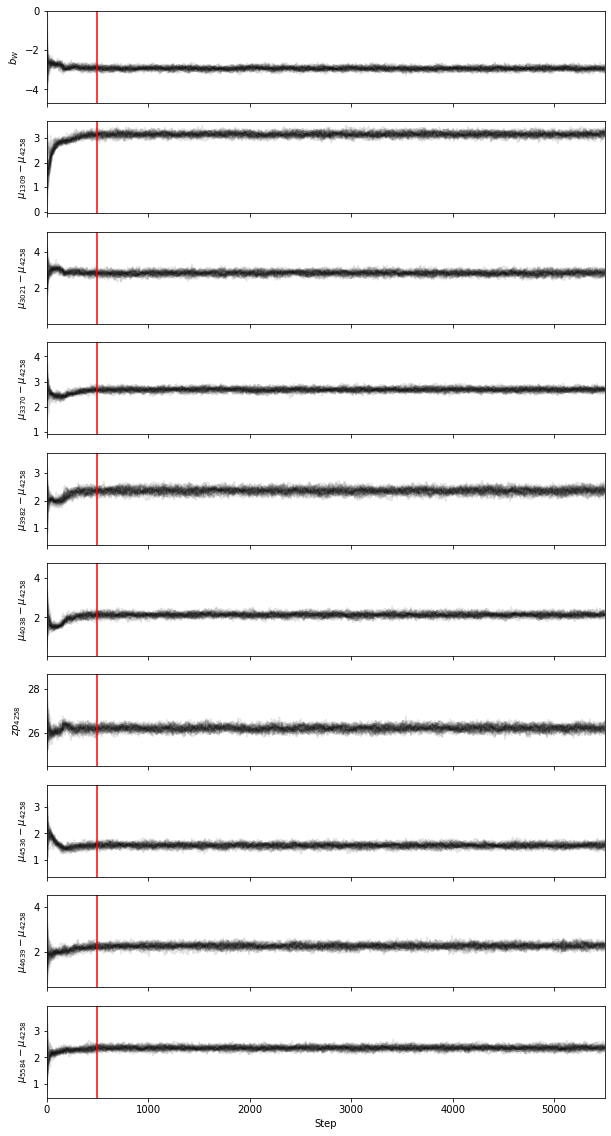

In [10]:
# get the samples
samp = sampler.get_chain()
full_sample = np.concatenate((burn, samp))

# make some labels 
labels = [r'$b_W$',] + [r'$\mu_{'+str(host)+r'} - \mu_{4258}$' if host !='4258' else r'$zp_{4258}$' for host in hosts]

# make a traceplot 
fig, axs = plt.subplots(nrows=ndim, ncols=1, figsize=(10, 20), sharex=True)
for i in range(ndim):
    ax = axs[i]
    ax.plot(full_sample[:,:,i], color='k', alpha=0.1 )
    ax.set_ylabel(labels[i])
    ax.set_xlim(0, nburnin+nsteps)
    ax.axvline(nburnin, color='red')
ax.set_xlabel('Step')

<font color='green'>
 
### Cornerplots.
    
</font>

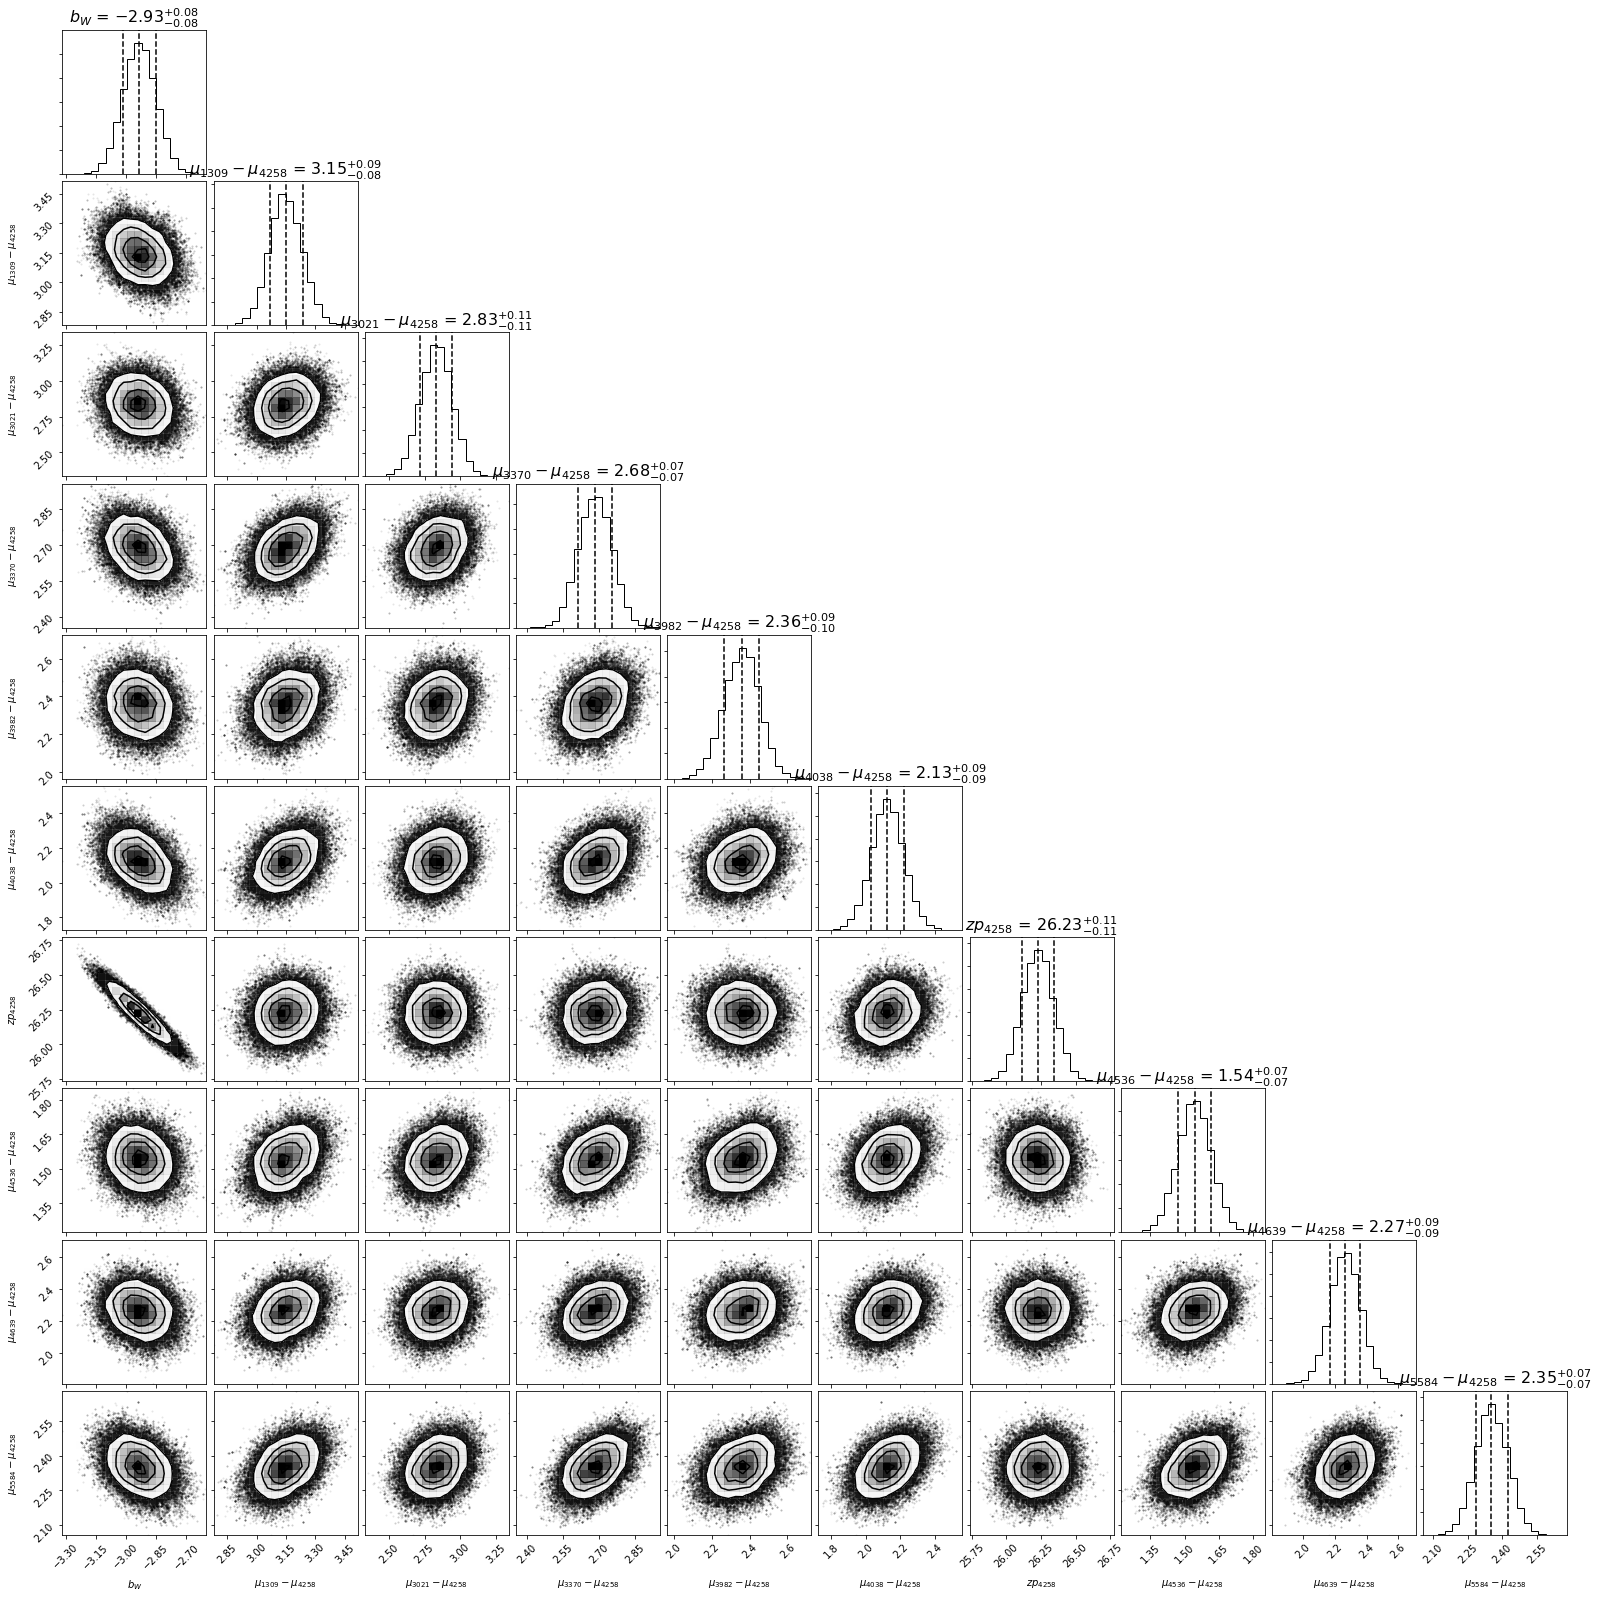

In [11]:
samp = samp.reshape((nwalkers*nsteps, ndim))
# make a corner plot
fig = corner.corner(samp, labels=labels, quantiles=[0.16, 0.5, 0.84],\
                       show_titles=True, title_kwargs={"fontsize": 16}) 

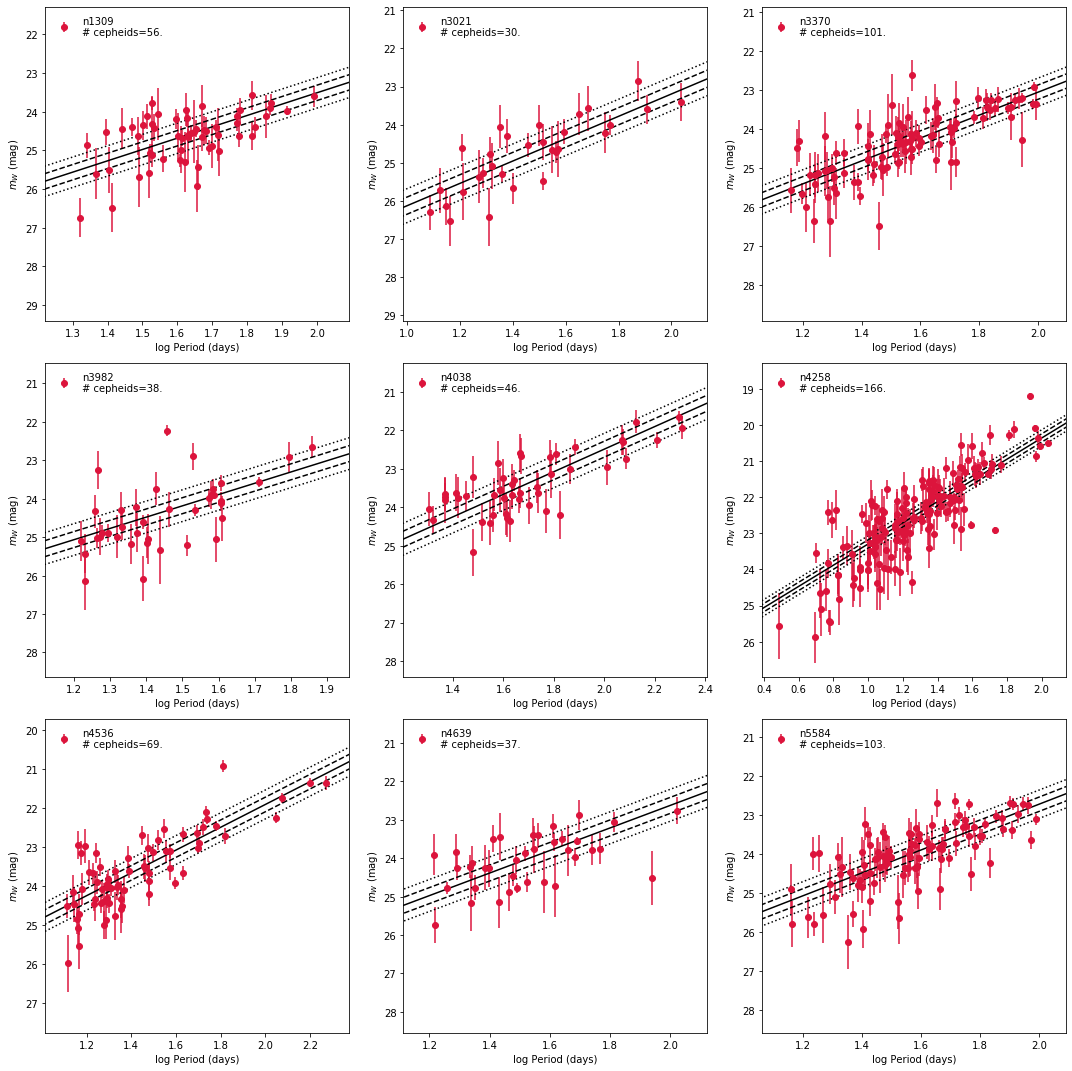

In [12]:
fig = plt.figure(figsize=(15, 15))
slope_lo, slope_mid, slope_hi = np.percentile(samp[:,0], [16, 50, 84])
zp_lo2, zp_lo, zp_mid, zp_hi, zp_hi2 = np.percentile(samp[:,ind4258+1],[2.4, 16, 50, 84, 97.6] )
res_mu = {}

for i, ID in enumerate(hosts):
    ax = fig.add_subplot(3, 3, i+1)
    
    low2, low, mid, high, high2 = np.percentile(samp[:,i+1], [2.4, 16, 50, 84, 97.6])
    ceph.select(ID)
    mobs = ceph.mobs
    logP = ceph.logP
    sigma_obs = ceph.sigma
    label = f'n{ID}\n# cepheids={len(mobs)}.'
    ax.errorbar(logP, mobs, yerr=sigma_obs, linestyle='None', marker='o', label=label, color='crimson')
    

    
    if ID != '4258':
        err = np.mean([high - mid, mid-low])
        res_mu[ID] = (mid, err)
        low2 += zp_lo2
        low  += zp_lo
        mid  += zp_mid
        high += zp_hi
        high2 += zp_hi2
        
        
    ax.plot(logPgrid, slope_mid*logPgrid + mid, 'k-')
    ax.plot(logPgrid, slope_mid*logPgrid + low, 'k--')
    ax.plot(logPgrid, slope_mid*logPgrid + high, 'k--')
    ax.plot(logPgrid, slope_mid*logPgrid + high2, 'k:')
    ax.plot(logPgrid, slope_mid*logPgrid + low2, 'k:')
    ax.invert_yaxis()
    ax.legend(loc='upper left', frameon=False)
    ax.set_xlim(logP.min()-0.1, logP.max()+0.1)
    ax.set_xlabel('log Period (days)')
    ax.set_ylabel(r'$m_W$ (mag)')
fig.tight_layout()
    

<font color='green'>
 
### Enter some data from Riess et al, 2011 for comparison with our results.
    
</font>

In [13]:
r11_mu = {'4536':(1.567, 0.0404),
          '4639':(2.383, 0.0630),
          '3370':(2.835, 0.0284),
          '3982':(2.475, 0.0460),
          '3021':(3.138, 0.0870),
          '1309':(3.276, 0.0491),
          '5584':(2.461, 0.0401),
          '4038':(2.396, 0.0567)} 


r11_m0 = {'4536':(15.147, 0.145),
          '4639':(16.040, 0.111),
          '3370':(16.545, 0.101),
          '3982':(15.953, 0.091),
          '3021':(16.699, 0.113),
          '1309':(16.768, 0.103),
          '5584':(16.274, 0.122),
          '4038':(15.901, 0.137)} 

<font color='green'>
 
### Compare the $\Delta\mu$s again R11.
    
</font>  

Text(0, 0.5, 'This work $\\mu_i - \\mu_{4258}$, (mag)')

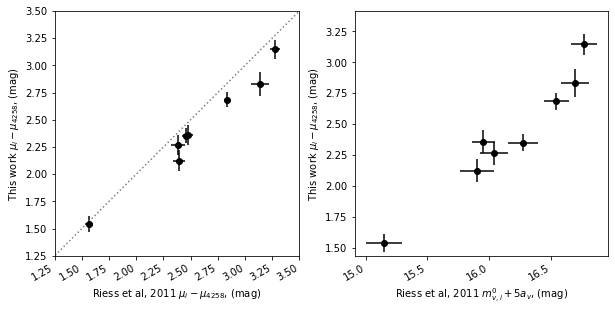

In [14]:
fig = plt.figure(figsize=(10, 5))
ax  = fig.add_subplot(121)
ax2 = fig.add_subplot(122, sharey=ax)
for host, val in r11_mu.items():
    x, xerr = val
    y, yerr = res_mu[host]
    z, zerr = r11_m0[host]
    ax.errorbar([x,], [y,], xerr=[xerr,], yerr=[yerr,], marker='o', color='k', ls='None')
    ax2.errorbar([z,], [y,], xerr=[zerr,], yerr=[yerr,], marker='o', color='k', ls='None')
    
xmin, xmax = ax.get_xlim()
xticks = ax.get_xticks()
ax.plot([0, 10], [0, 10], linestyle=':', color='grey')
ax.set_xlim(xmin, xmax)
ax.set_ylim(xmin, xmax)

ax.set_xticks(xticks)
ax.set_yticks(xticks)
ax.set_aspect('equal')
fig.autofmt_xdate()

ax.set_xlabel('Riess et al, 2011' + r' $\mu_i - \mu_{4258}$, (mag)')
ax.set_ylabel('This work' + r' $\mu_i - \mu_{4258}$, (mag)')

ax2.set_xlabel('Riess et al, 2011' + r' $m^0_{v,i} + 5a_v$, (mag)')
ax2.set_ylabel('This work' + r' $\mu_i - \mu_{4258}$, (mag)')

# Q4.

## Riess et al. do a *simultaneous* fit to the Cepheids and SNe data (Table 3 of their paper). 

## I'm slightly less cruel, so you can take your intercepts $\mu_{0,i} - \mu_{0, 4258}$ and the re-express equation 4 using a substitution of equation 3.

## Write that expression down.

<font color='green'>

### Define the offsets we solved for as:
    
# $$ \Delta\mu_i = \mu_{i} - \mu_{4258} $$  
    
### Then, Eqn 3. is
    
# $$ m^0_{v,i} = \Delta\mu_i + m^0_{v, 4258} $$
    
### And Eqn 4. is
   
# $$ \log H_0 = \frac{m^0_{v, 4258} - \mu_{0, 4258} + 5a_v + 25}{5} $$
    
### So:
    
#  $$ \log H_{0,i} = \frac{ (m^0_{v,i} + 5a_v) - (\Delta\mu_i + \mu_{0, 4258})   + 25}{5} $$   
    
### i.e. each galaxy with Cepheids and a SN distance gives an independent estimate of the Hubble constant, with the zeropoint set by an independent (geometrical distance modulus) to NGC4258.
    
</font>

# Q5

## Using the supernova data in Table 3 (enter it into whatever data structure you deem best) and the distance modulus to NGC 4258 from [Humphreys et al., 2013 ](https://ui.adsabs.harvard.edu/abs/2013ApJ...775...13H/abstract) and using the simple sample statistics you learned in Week 1, estimate the Hubble constant.

In [15]:
logH0i = []
dlogH0i = []

# the Humphreys et al., 2013 distance
mu4258 = 5.*np.log10(7.6*10**6/10.)

# the paper also specifies an uncertainty on the NGC4258 distance - we'll use the statistical uncertainty
# there is also a systematic uncertainty, but that error doesn't make sense to just include in quadrature
sig_mu4258=0.17

# compute H0 for each Cepehid galaxy
for host, val in r11_m0.items():
    m5av, dm5av = val
    dmu, err = res_mu[host]
    logH0i.append(((m5av - (dmu + mu4258) + 25)/5.))
    dlogH0i.append(np.sqrt(dm5av**2. + err**2.)/5.)

# make them arrays    
logH0i = np.array(logH0i)
dlogH0i = np.array(dlogH0i)

# we just weight by the uncertainty frome each of our estimates
w = 1./dlogH0i**2.

# compute the weighted average
logH0, wsum = np.average(logH0i, weights=w, returned=True)
dlogH0 = wsum**-0.5

# all of the galaxies are offset relative to NGC4258 so that error will dominate
errlogH0 = np.sqrt(dlogH0**2. + (sig_mu4258/5.)**2)

H = 10**(ufloat(logH0, errlogH0))
print(f' Halfway reasonable estimate of H0: {H:.3f}')

 Halfway reasonable estimate of H0: 74.047+/-6.046
